In [1]:
import numpy as np
import matplotlib.pyplot as plt
import batman, catwoman
from multiprocessing import Pool
import emcee

In [2]:
AU_to_meter = 1.496e11
day_to_second = 24.*60.*60.
Rsun_to_meter = 6.957e8
Rjup_to_meter = 7.149e7
Mjup_to_kg = 1.899e27

# create a planet
t0 = 0. # [day]
P = 5.0 #4.0552941 # [day]
aRs = 12.0 #11.55 # [stellar radii]
inc = 87.3 #87.32 # [degrees]
ecc = 0.
w = 90.
rprs1 = 0.1 # 
rprs2 = rprs1*(1.5)
Rs = 1.0 #0.92868 # [Rsun]
Rp1 = rprs1*Rs # [Rsun]
Rp2 = rprs2*Rs # [Rsun]

# calculate things in physical units
a_meter = aRs * Rs * Rsun_to_meter
P_seconds = P*day_to_second
Rs_meter = Rs * Rsun_to_meter
Rp1_meter = Rp1 * Rsun_to_meter
Rp2_meter = Rp2 * Rsun_to_meter

# calculate other things
v_orb = (2.*np.pi*a_meter) / (P_seconds) # [m/s]

# high res. time axis
preT14 = 5.0
t_int = 0.1*preT14 # [s] per integration
obs_window_size = (0.65*preT14) / 24. # half-duration of whole observation in [day]
t = np.arange(-obs_window_size, obs_window_size, (t_int / 60./60./24.))

In [3]:
aparams  = catwoman.TransitParams()
aparams.t0 = t0                          #time of inferior conjuction (in days)
aparams.per = P                         #orbital period (in days)
aparams.rp = rprs1                        #top semi-circle radius (in units of stellar radii)
aparams.rp2 = rprs2                        #bottom semi-circle radius (in units of stellar radii)
aparams.a = aRs                         #semi-major axis (in units of stellar radii)
aparams.inc = inc                        #orbital inclination (in degrees)
aparams.ecc = ecc                        #eccentricity
aparams.w = w                         #longitude of periastron (in degrees)
aparams.limb_dark = "uniform"          #limbs darkening model
aparams.phi = 90.0                         #angle of rotation of top semi-circle (in degrees)
asymmodel = catwoman.TransitModel(aparams,t)         #initalises model
asym_lc = asymmodel.light_curve(aparams)

uparams  = batman.TransitParams()
uparams.t0 = t0                          #time of inferior conjuction (in days)
uparams.per = P                         #orbital period (in days)
uparams.rp = rprs2                       #top semi-circle radius (in units of stellar radii)
uparams.a = aRs                         #semi-major axis (in units of stellar radii)
uparams.inc = inc                        #orbital inclination (in degrees)
uparams.ecc = ecc                        #eccentricity
uparams.w = w                         #longitude of periastron (in degrees)
uparams.u = []                   #limb darkening coefficients [u1, u2]
uparams.limb_dark = "uniform"          #limbs darkening model
unifmodel = batman.TransitModel(uparams,t)         #initalises model

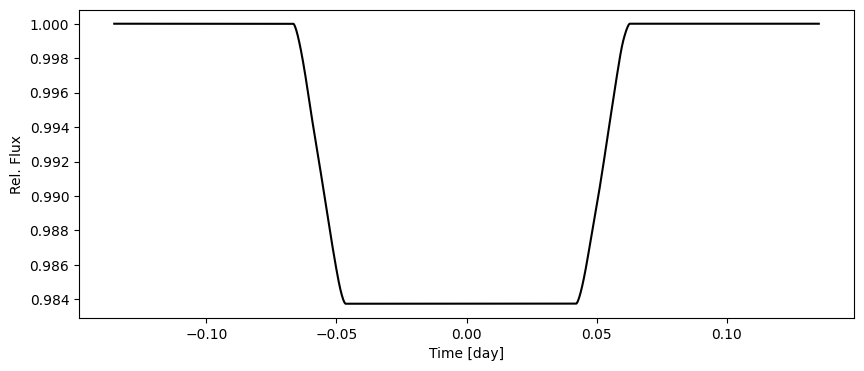

In [4]:
fig, ax = plt.subplots(figsize=(10,4))
ax.plot(t, asym_lc, c='black')
ax.set(xlabel='Time [day]', ylabel='Rel. Flux')
plt.show()

In [5]:
def calc_b(aRs, inc):
    # aRs = a in [Rstar]
    # inc in [deg]
    b = aRs*np.cos(inc*(np.pi/180.))
    return b

def calc_phis(b, Rs, Rp1, Rp2):
    # b is unitless
    # Rs, Rp1, Rp2 all in same units, doesn't matter exactly what
    bRs = b*Rs 
    sinphi1 = bRs / (Rs + Rp2)
    cosphi2 = bRs / (Rs - Rp1)
    cosphi3 = bRs / (Rs - Rp2)
    sinphi4 = bRs / (Rs + Rp1)
    
    phi1 = np.arcsin(sinphi1)
    phi2 = np.arccos(cosphi2)
    phi3 = np.arccos(cosphi3)
    phi4 = np.arcsin(sinphi4)
    
    return phi1, phi2, phi3, phi4  

def calc_x12(Rs, Rp1, Rp2, phi1, phi2):
    term1 = (Rs - Rp1)**2
    term2 = (Rs + Rp2)**2
    term3 = (Rs - Rp1) * (Rs + Rp2)
    phiadd = phi1 + phi2
    costerm = np.cos((np.pi/2.) - phiadd)
    dx2 = term1 + term2 - (2.*term3*costerm)
    dx12 = np.sqrt(dx2)
    return dx12

def calc_xcomb(Rs, Rp2, phi2, b):
    A2 = (Rp2**2) + (2.*Rs*Rp2) + ((Rs**2)*(1 - (b**2)))
    A = np.sqrt(A2)
    term2 = b*Rs
    trigterm = np.tan((np.pi/2.)-phi2)
    dxc = A - (term2/trigterm)
    return dxc

In [6]:
# calculate impact parameter
b = calc_b(aRs, inc)
# calculate phis
phi1, phi2, phi3, phi4 = calc_phis(b, Rs, Rp1, Rp2) # inputs are in [Rsun], output in [radians]
# calculate projected paths
dx_12 = calc_x12(Rs_meter, Rp1_meter, Rp2_meter, phi1, phi2)
dx_comb = calc_xcomb(Rs_meter, Rp2_meter, phi2, b)

# calculate corresponding duration, assuming linear path
T12_calc1_s = dx_12 / v_orb # [s]
T12_calc1 = T12_calc1_s / 60./60./24. # [day]

Tcomb_calc1_s = dx_comb / v_orb
Tcomb_calc1 = Tcomb_calc1_s / 60./60./24.

# calculate, accounting for orbital path, small angle approx.
theta_12 = dx_12 / a_meter # radians
omega = (2.*np.pi)/P_seconds # radians per second
T12_calc2_s = theta_12 / omega # second
T12_calc2 = T12_calc2_s / 60./60./24. # [day]

print('Angles ----')
print('inc = %.1f deg'%(inc))
print('b = %.2f'%(b))
print('phi1 = %.2f deg'%(phi1*(180./np.pi)))
print('phi2 = %.2f deg'%(phi2*(180./np.pi)))
print('phi3 = %.2f deg'%(phi3*(180./np.pi)))
print('phi4 = %.2f deg'%(phi4*(180./np.pi)))
print('Paths ----')
print('Rp1 + Rp2 = %.1f m'%(Rp1_meter + Rp2_meter))
print('dx 1-2 = %.1f m'%(dx_12))
print('dx comb = %.1f m'%(dx_comb))
print('Durations ----')
print('T12, calc1 = %.4f day'%(T12_calc1))
print('Tcomb, calc1 = %.4f day'%(Tcomb_calc1))
#print('T12, calc2 = %.4f day'%(T12_calc2))

Angles ----
inc = 87.3 deg
b = 0.57
phi1 = 29.44 deg
phi2 = 51.09 deg
phi3 = 48.32 deg
phi4 = 30.92 deg
Paths ----
Rp1 + Rp2 = 173925000.0 m
dx 1-2 = 209510124.9 m
dx comb = 209510124.9 m
Durations ----
T12, calc1 = 0.0200 day
Tcomb, calc1 = 0.0200 day


In [7]:
## functions to measure the points of transit contact
## ASSUMING UNIFORM LD LAW
def get_T1_index(time, y):
    # get the index where T1 occurs
    # defined as where model flux first goes < 1
    pretransit_idxs = np.where((y == 1.0) & (time < np.median(time)))[0] # 'oot' indexes
    T1_idx = pretransit_idxs[-1] 
    return T1_idx

def get_T4_index(time, y):
    # get the index where T4 occurs
    # defined as where model flux last goes = 1
    posttransit_idxs = np.where((y == 1.0) & (time > np.median(time)))[0] # 'oot' indexes
    T4_idx = posttransit_idxs[0] 
    return T4_idx

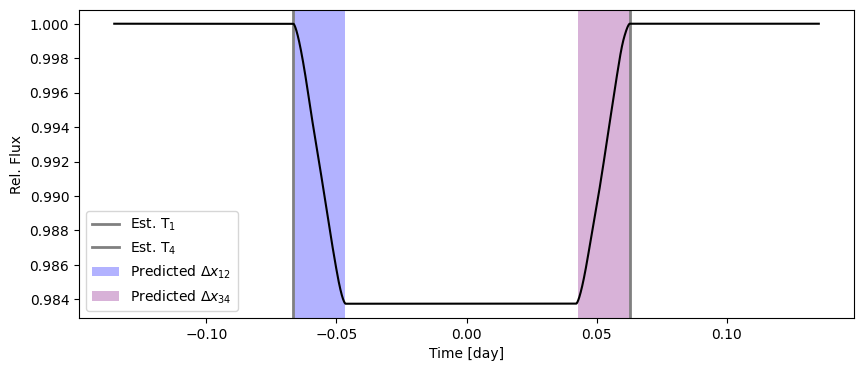

In [9]:
t1idx = get_T1_index(t, asym_lc)
t4idx = get_T4_index(t, asym_lc)
t1 = t[t1idx]
t4 = t[t4idx]

fig, ax = plt.subplots(figsize=(10,4))
ax.axvline(t1, c='gray', lw=2, label='Est. T$_1$')
ax.axvline(t4, c='gray', lw=2, label='Est. T$_4$')

ax.axvspan(t1, t1+T12_calc1, fc='blue', alpha=0.3, label='Predicted $\Delta x_{12}$')
ax.axvspan(t4, t4-T12_calc1, fc='purple', alpha=0.3, label='Predicted $\Delta x_{34}$')

ax.plot(t, asym_lc, c='black')
ax.set(xlabel='Time [day]', ylabel='Rel. Flux')
ax.legend(loc='best')
plt.show()

In [ ]:
## functions to measure the points of transit contact
## ASSUMING UNIFORM LD LAW
def get_T1_index(time, y):
    # get the index where T1 occurs
    # defined as where model flux first goes < 1
    pretransit_idxs = np.where((y == 1.0) & (time < np.median(time)))[0] # 'oot' indexes
    T1_idx = pretransit_idxs[-1] 
    return T1_idx
def get_T4_index(time, y):
    # get the index where T4 occurs
    # defined as where model flux last goes = 1
    posttransit_idxs = np.where((y == 1.0) & (time > np.median(time)))[0] # 'oot' indexes
    T4_idx = posttransit_idxs[0] 
    return T4_idx
def get_T2_index(time, y, asymmetric='no'):
    # get index where T2 occurs 
    fulldepth = np.min(y) # full-depth is the minimum model flux
    if asymmetric == 'no':
        # -- works best for uniform limb LC
        # we assume uniform LD, so depth is same during entire full transit
        # then, T2 is point where depth switches from > full-depth to = full-depth
        fulltransit_idxs = np.where(y == fulldepth)[0]
        T2_idx = fulltransit_idxs[0] - 1
        return T2_idx
    elif asymmetric == 'yes':
        # -- works for asymmetry up to at least 20%
        ft_idx = np.array([])
        ref = float('%.4f'%(fulldepth))
        for i, yval in enumerate(y):
            cy = float('%.4f'%(yval))
            if cy == ref:
                ft_idx = np.append(ft_idx, i)
        T2_idx = int(ft_idx[0])
        return T2_idx

def get_T3_index(time, y, asymmetric='no'):
    # get index where T3 occurs 
    fulldepth = np.min(y) # full-depth is the minimum model flux
    if asymmetric == 'no':
        # -- works best for uniform limb LC
        # we assume uniform LD, so depth is same during entire full transit
        # then, T3 is point where depth switches from = full-depth to > full-depth
        fulltransit_idxs = np.where(y == fulldepth)[0]
        T3_idx = fulltransit_idxs[-1] 
        return T3_idx
    elif asymmetric == 'yes':
        # -- works for asymmetry up to at least 20%
        ft_idx = np.array([])
        ref = float('%.4f'%(fulldepth))
        for i, yval in enumerate(y):
            cy = float('%.4f'%(yval))
            if cy == ref:
                ft_idx = np.append(ft_idx, i)
        T3_idx = int(ft_idx[-1])
        return T3_idx

In [ ]:
## Comparing this to a batman model ----
comp_lc = unifmodel.light_curve(uparams)

# get model contact points
T1guess = t[get_T1_index(t, comp_lc)]
T2guess = t[get_T2_index(t, comp_lc, asymmetric='no')]
T3guess = t[get_T3_index(t, comp_lc, asymmetric='no')]
T4guess = t[get_T4_index(t, comp_lc)]
# compute model-derived durations
T14_model = T4guess - T1guess
T12_model = T2guess - T1guess
T34_model = T4guess - T3guess
T23_model = T3guess - T2guess
T13_model = T3guess - T1guess

print('Model values --')
print('T13 = %.2f min'%(T13_model*24.*60.))
print('T34 = %.2f min'%(T34_model*24.*60.))
print('T14 = %.2f min'%(T14_model*24.*60.))
# print('T12 = %.2f min'%(T12_model*24.*60.))
# print('T34 = %.2f min'%(T34_model*24.*60.))


# compute corresponding analytic-formula-derived durations in [s]
T14_lit = lit_T14(Rs_meter, Rp_meter, aRs, inc, per) #[day]
# # convert to [day] like model values

# # compute corresponding contact points
# T2_analy = -0.5*T23_analy
# T3_analy = 0.5*T23_analy
#T1_analy = -0.5*T14_analy
#T2_analy = T1_analy + T12_analy
#T4_analy = 0.5*T14_analy
#T3_analy = T4_analy - T34_analy


print('Analytic predictions --')
# print('T13 = %.2f min'%(T13_analy*24.*60.))
# print('T34 = %.2f min'%(T34_analy*24.*60.))
print('lit T14 = %.2f min'%(T14_lit*24.*60.))
#print('T12 = %.2f min'%(T12_analy*24.*60.))
#print('T34 = %.2f min'%(T34_analy*24.*60.))

# compare
#T14_ratio = T14_model / T14_analy
#T12_ratio = T12_model / T12_analy
#T34_ratio = T34_model / T34_analy

print('Model value / Analytic value ---')
#print('T14 ratio = %.3f'%(T14_ratio))
#print('T12 ratio = %.3f'%(T12_ratio))
#print('T34 ratio = %.3f'%(T34_ratio))

fig, ax = plt.subplots(figsize=(10,4))
ax.axvline(T1guess, c='blue', lw=0.5, alpha=0.3)
ax.axvline(T2guess, c='blue', lw=0.5, alpha=0.3)
ax.axvline(T3guess, c='blue', lw=0.5, alpha=0.3)
ax.axvline(T4guess, c='blue', lw=0.5, alpha=0.3)
#ax.axvline(T1_analy, c='orange', lw=0.5, alpha=0.3)
# ax.axvline(T2_analy, c='orange', lw=0.5, alpha=0.3)
# ax.axvline(T3_analy, c='orange', lw=0.5, alpha=0.3)
#ax.axvline(T4_analy, c='orange', lw=0.5, alpha=0.3)
#ax.axvline(0.5*T14_analy, c='purple', lw=0.5, alpha=0.4)
#ax.axvline(-0.5*T14_analy, c='purple', lw=0.5, alpha=0.4)
ax.plot(t, comp_lc, c='black')
plt.show()

In [ ]:
T14_lit